In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from funcs import set_dataset, make_rnn

2024-11-04 08:54:51.078391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 08:54:51.284037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 08:54:51.349266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 08:54:51.372712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 08:54:51.528457: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# TODO: Ver si las categorias se influyen entre si
# TODO: 

In [3]:
df = pd.read_csv('../data/Desafio Ds 2025 - Gen AI/series.csv')
df = df.sort_values(by='DATE')

In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
print(df['DATE'].min())
print(df['DATE'].max())
print(df['DATE'].max() - df['DATE'].min())

2018-09-24 00:00:00
2021-11-12 00:00:00
1145 days 00:00:00


In [5]:
df['DAYWEEK'] = df['DATE'].dt.dayofweek
df['MONTH'] = df['DATE'].dt.month
df['DAYMONTH'] = df['DATE'].dt.day
df['LAG_1'] = df['UNITS_SOLD'].shift(1)
df['LAG_7'] = df['UNITS_SOLD'].shift(7)
df['LAG_30'] = df['UNITS_SOLD'].shift(30)

In [6]:
df_trial = df[df['CATEGORY'] == 'CATEG-1'].drop('CATEGORY', axis=1)

# Checks

In [7]:
df_trial[df_trial['UNITS_SOLD'] < 0]

Empty DataFrame
Columns: [DATE, UNITS_SOLD, DAYWEEK, MONTH, DAYMONTH, LAG_1, LAG_7, LAG_30]
Index: []

In [8]:
df_trial = df_trial.set_index('DATE')
df_trial

UNITS_SOLD  DAYWEEK  MONTH  DAYMONTH   LAG_1   LAG_7  LAG_30
DATE                                                                    
2018-10-16           1        1     10        16     1.0     2.0     NaN
2019-06-11          27        1      6        11     0.0     0.0     2.0
2019-06-12          26        2      6        12   642.0     0.0     0.0
2019-06-13          24        3      6        13   561.0    15.0     2.0
2019-06-14          18        4      6        14    24.0   642.0     1.0
...                ...      ...    ...       ...     ...     ...     ...
2021-11-08          63        0     11         8  2576.0    18.0    12.0
2021-11-09          65        1     11         9    13.0    46.0  1597.0
2021-11-10         189        2     11        10    18.0  2812.0     9.0
2021-11-11         194        3     11        11  6294.0    13.0  1979.0
2021-11-12         146        4     11        12   194.0    65.0    37.0

[887 rows x 7 columns]

In [9]:
df_trial.index = pd.to_datetime(df_trial.index)
date_diff = df_trial.index.to_series().diff().dt.days
df_trial = df_trial[(date_diff == 1)]
df_trial

UNITS_SOLD  DAYWEEK  MONTH  DAYMONTH   LAG_1   LAG_7  LAG_30
DATE                                                                    
2019-06-12          26        2      6        12   642.0     0.0     0.0
2019-06-13          24        3      6        13   561.0    15.0     2.0
2019-06-14          18        4      6        14    24.0   642.0     1.0
2019-06-15          15        5      6        15   520.0   679.0     1.0
2019-06-16          11        6      6        16     7.0    18.0     1.0
...                ...      ...    ...       ...     ...     ...     ...
2021-11-08          63        0     11         8  2576.0    18.0    12.0
2021-11-09          65        1     11         9    13.0    46.0  1597.0
2021-11-10         189        2     11        10    18.0  2812.0     9.0
2021-11-11         194        3     11        11  6294.0    13.0  1979.0
2021-11-12         146        4     11        12   194.0    65.0    37.0

[885 rows x 7 columns]

# Modelado

In [10]:
original_data_train = df_trial[(df_trial.index < '2021-08-12') & (df_trial.index >= '2019-06-12')]
original_data_val = df_trial[(df_trial.index < '2021-10-20') & (df_trial.index >= '2021-08-12')]
original_data_test = df_trial[df_trial.index >= '2021-10-20']

In [11]:
sequence_length = 1
ahead = 21
batch_size = 16

In [12]:
original_data_train.head()

UNITS_SOLD  DAYWEEK  MONTH  DAYMONTH  LAG_1  LAG_7  LAG_30
DATE                                                                  
2019-06-12          26        2      6        12  642.0    0.0     0.0
2019-06-13          24        3      6        13  561.0   15.0     2.0
2019-06-14          18        4      6        14   24.0  642.0     1.0
2019-06-15          15        5      6        15  520.0  679.0     1.0
2019-06-16          11        6      6        16    7.0   18.0     1.0

In [13]:
data_train = set_dataset(original_data_train, seq_length=sequence_length, ahead=ahead, batch_size=batch_size, shuffle=False)
data_val = set_dataset(original_data_val, seq_length=sequence_length, ahead=ahead)

I0000 00:00:1730721293.705459    1549 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-04 08:54:53.811257: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


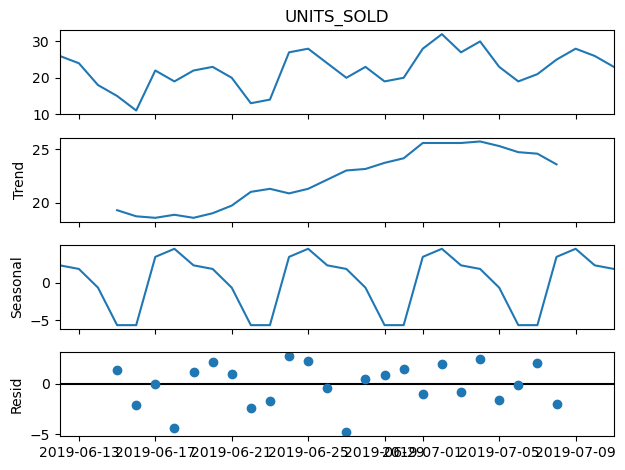

In [26]:
decomposition = sm.tsa.seasonal_decompose(original_data_train['UNITS_SOLD'][:30], model='additive')
fig = decomposition.plot()
plt.show()

In [20]:
sarima_df = original_data_train['UNITS_SOLD']
model = SARIMAX(sarima_df, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = model.fit()

sarima_fit.summary()

/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07884D+00    |proj g|=  4.64923D-02

At iterate    5    f=  4.01376D+00    |proj g|=  8.47681D-02

At iterate   10    f=  3.96550D+00    |proj g|=  3.04911D-03

At iterate   15    f=  3.96071D+00    |proj g|=  2.00367D-02

At iterate   20    f=  3.95843D+00    |proj g|=  1.32231D-03

At iterate   25    f=  3.95842D+00    |proj g|=  3.84944D-04

At iterate   30    f=  3.95840D+00    |proj g|=  3.11818D-03

At iterate   35    f=  3.95833D+00    |proj g|=  1.14898D-03

At iterate   40    f=  3.95831D+00    |proj g|=  6.91490D-05

At iterate   45    f=  3.95831D+00    |proj g|=  8.20217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        UNITS_SOLD   No. Observations:                  792
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3134.979
Date:                           Mon, 04 Nov 2024   AIC                           6279.957
Time:                                   10:49:35   BIC                           6303.279
Sample:                               06-12-2019   HQIC                          6288.925
                                    - 08-11-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7639      0.030     25.176      0.000       0.704       0.823
ma.L1         -0.9308      0.021    -44.311      0.000      -0.972      -0.890
ar.S.L7        0.0718      0.031      2.331      0.020       0.011       0.132
ma.S.L7       -0.9998      1.333     -0.750      0.453      -3.612       1.613
sigma2       166.7131    220.459      0.756      0.450    -265.379     598.805
===================================================================================
Ljung-Box (L1) (Q):                   4.21   Jarque-Bera (JB):             28821.48
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.71
Prob(H) (two-sided):                  0.16   Kurtosis:                        32.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast_val_mean = sarima_fit.get_forecast(steps=len(original_data_val)).predicted_mean

mae = mean_absolute_error(original_data_val['UNITS_SOLD'], forecast_val_mean)
mae

7.927248259178782

In [17]:
"""
trials = 5
tuner2 = kt.BayesianOptimization(hypermodel=make_rnn, objective='val_mae', max_trials=trials, max_retries_per_trial=0, max_consecutive_failed_trials=trials, overwrite=True, project_name='RNN', seed=47)

rlr2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
es2 = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=20, restore_best_weights=True)

tuner2.search(data_train_2, batch_size=batch_size, validation_data=(data_val), callbacks=[es2, rlr2], epochs=100000)

bestmodel2 = tuner2.get_best_models(num_models=1)[0]
best_hp2 = tuner2.get_best_hyperparameters()[0]

print(best_hp2.values)
"""

Trial 5 Complete [00h 06m 27s]
val_mae: 6.041439056396484

Best val_mae So Far: 5.995699405670166
Total elapsed time: 00h 42m 13s
{'model_length': 5, 'size': 250, 'dropout_percentage': 0.30000000000000004, 'chosen_optimizer': 'nadam', 'learning_rate': 5.287479707924124e-05, 'decay': 0.4285424360064111}


/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 37 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
trials = 100
tuner = kt.BayesianOptimization(hypermodel=make_rnn, objective='val_mae', max_trials=trials, max_retries_per_trial=0, max_consecutive_failed_trials=trials, overwrite=True, project_name='RNN', seed=47)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=30, restore_best_weights=True)

tuner.search(data_train, batch_size=batch_size, validation_data=(data_val), callbacks=[es, rlr], epochs=10000)

bestmodel = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters()[0]

print(best_hp.values)

Trial 20 Complete [00h 02m 58s]
val_mae: 5.9726996421813965

Best val_mae So Far: 5.972541332244873
Total elapsed time: 00h 36m 24s
{'model_length': 7, 'size': 65, 'dropout_percentage': 0.2, 'chosen_optimizer': 'nadam', 'learning_rate': 5.449770094577858e-05, 'decay': 0.33350097698667636}


/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 49 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
y_pred = bestmodel.predict(original_data_test.to_numpy()[np.newaxis, :1])[0, -1]
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([41.200714, 41.195663, 40.97749 , 40.823895, 41.235058, 41.48063 ,
       41.118935, 41.289253, 41.23246 , 41.456863, 41.034588, 41.45377 ,
       41.76634 , 42.02383 , 41.440514, 41.95034 , 41.98299 , 42.166058,
       41.8528  , 41.84627 , 42.063618], dtype=float32)

In [40]:
mean_absolute_error(original_data_test['UNITS_SOLD'][:21], sarima_fit.get_forecast(steps=21).predicted_mean)

10.903626441699155

In [39]:
mean_absolute_error(original_data_test['UNITS_SOLD'][:21], y_pred)

8.317757197788783